In [557]:
import numpy as np

from collections import defaultdict

from math import pi

from qiskit import transpile

from qiskit.circuit import QuantumCircuit, Parameter

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import StatevectorEstimator, StatevectorSampler

from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_aer import AerSimulator

from scipy.optimize import minimize



$ H(x) = - \sum_i v_i x_i + A(\sum_i w_i x_i - C)^2 $

$A$ is a penalty constant $>$ max($w_i$)

Map binary $x_i = (1 - Z_i) / 2$ into Pauli-Z operators

In [ ]:
def INVALID_create_knapsack_hamiltonian(weights, vals, cap, penalty):
    n = len(vals)

    Q = np.zeros((n, n))
    lin = np.zeros(n)

    # obj: -v_i x_i
    lin -= np.array(vals)
    
    for i in range(n):
        lin[i] += penalty * (weights[i] ** 2 - 2 * cap * weights[i])
        for j in range(i + 1, n):
            Q[i, j] += 2 * penalty * weights[i] * weights[j]

    # const = penalty * cap ** 2

    # map to hamiltonian / ising
    paulis = []
    coeffs = []

    for i in range(n):
        # linear term
        if abs(lin[i]) > 1e-9:
            coeffs.append(lin[i] / 2)
            paulis.append("I" * (n - i - 1) + "Z" + "I" * i)

    for i in range(n):
        for j in range(i + 1, n):
            if abs(Q[i, j]) > 1e-9:
                coeffs.append(Q[i, j] / 4)
                label = ["I"] * n
                label[n - i - 1] = "Z"
                label[n - j - 1] = "Z"
                paulis.append("".join(label))
    
    hamiltonian = SparsePauliOp.from_list(list(zip(paulis, coeffs)))
    return hamiltonian
    

$ x_i = \frac{1 - Z_i}{2} $

Linear Term

$ a_i x_i = \frac{a_i}{2} I - \frac{a_i}{2} Z_i $

Quadratic Term

$ b_{ij} x_i x_j = \frac{b_{ij}}{4} I - \frac{b_{ij}}{4} Z_i - \frac{b_{ij}}{4} Z_j + \frac{b_{ij}}{4} Z_i Z_j$  

$ h_i = -\frac{a_i}{2} - \frac{1}{4} \sum_{j \neq i} b_{ij} $

In [625]:
def create_knapsack_hamiltonian(weights, vals, cap, penalty):
    n = len(vals)

    Q = np.zeros((n, n))
    lin = np.zeros(n)

    lin -= np.array(vals, dtype=float)

    for i in range(n):
        lin[i] += penalty * (weights[i] ** 2 - 2 * cap * weights[i])
        for j in range(i + 1, n):
            Q[i, j] += 2 * penalty * weights[i] * weights[j]
    
    h = np.zeros(n)
    J = {}

    h += -lin / 2.0
    for i in range(n):
        for j in range(i + 1, n):
            bij = Q[i, j]
            if abs(bij) > 1e-12:
                h[i] += -bij / 4.0
                h[j] += -bij / 4.0
                J[(i, j)] = J.get((i, j), 0.0) + bij / 4.0
    
    paulis, coeffs = [], []
    for i, c in enumerate(h):
        if abs(c) > 1e-12:
            label = ["I"] * n
            label[n - i - 1] = "Z"
            paulis.append("".join(label))
            coeffs.append(c)
    for (i, j), c in J.items():
        if abs(c) > 1e-12:
            label = ["I"] * n
            label[n - i - 1] = "Z"
            label[n - j - 1] = "Z"
            paulis.append("".join(label))
            coeffs.append(c)

    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

In [626]:
vals = [5, 4, 6]
weights = [2, 3, 4]
cap = 5
pen = 4#sum(vals) #10 # > max(weights)

# problem hamiltonian
hamiltonian = create_knapsack_hamiltonian(weights, vals, cap, pen)

print(hamiltonian)

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[ 6.5+0.j,  8. +0.j, 11. +0.j, 12. +0.j, 16. +0.j, 24. +0.j])


In [627]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

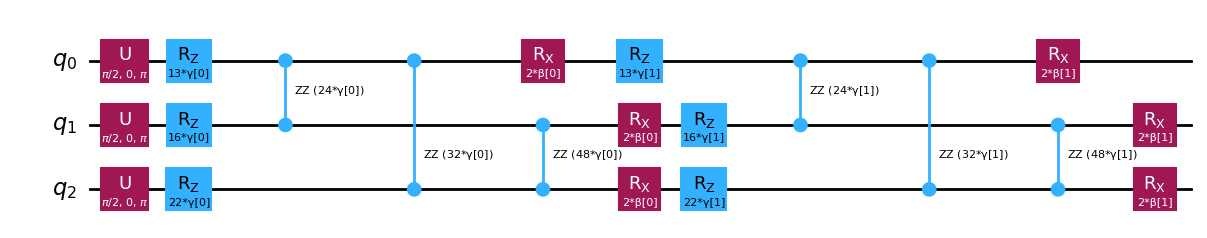

In [628]:
ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=2).draw("mpl")

In [629]:
estimator = StatevectorEstimator()

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

cost = cost_func(x0, ansatz, hamiltonian, estimator)
print(cost)

-8.854968437906582


In [630]:
res = minimize(cost_func, x0, 
               args=(ansatz, hamiltonian, estimator),
               method="COBYLA")
print("Optimal params:", res.x)
print("Estimated ground state energy:", res.fun)

Optimal params: [1.23445397 4.08907603 1.25420366 1.82601087]
Estimated ground state energy: -25.111429871633597


In [635]:
qc = ansatz.decompose(reps=2) # =3)
qc = qc.copy()
qc.measure_all()
bound = qc.assign_parameters(res.x)

backend = AerSimulator()
tqc = transpile(bound, backend)
job = backend.run(tqc, shots=2048)
counts = job.result().get_counts()

print(counts)

{'010': 211, '100': 439, '011': 844, '101': 448, '111': 49, '001': 27, '110': 22, '000': 8}


In [636]:
total = sum(counts.values())
dist = {int(bitstr, 2): cnt / total for bitstr, cnt in counts.items()}

def bits_from_int(k, width):
    b = format(k, f"0{width}b")
    return list(reversed([int(ch) for ch in b]))

def score(x_bits):
    val = sum(v for v, b in zip(vals, x_bits) if b)
    wt = sum(w for w, b in zip(weights, x_bits) if b)
    return val, wt

n = len(vals)

best = (None, -1, None, 0.0)  # (x_bits, value, weight, prob)
for k, p in dist.items():
    x = bits_from_int(k, n)
    val, wt = score(x)
    if wt <= cap and val > best[1]:
        best = (x, val, wt, float(p))


x_bits, best_val, best_wt, best_prob = best
picked = [i for i, b in enumerate(x_bits or []) if b]

print("\nBest (feasible) sample:")
print("  items picked:", picked)
print("  bitstring   :", ''.join(map(str, x_bits or [])))
print("  value/weight:", best_val, "/", best_wt, f"(capacity {cap})")
print("  sample prob :", best_prob)


Best (feasible) sample:
  items picked: [0, 1]
  bitstring   : 110
  value/weight: 9 / 5 (capacity 5)
  sample prob : 0.412109375


In [637]:
print(dist)

{2: 0.10302734375, 4: 0.21435546875, 3: 0.412109375, 5: 0.21875, 7: 0.02392578125, 1: 0.01318359375, 6: 0.0107421875, 0: 0.00390625}
